In [1]:
from helpers import *

#### 1. Import and save data from binance into csv

In [3]:
'''
directory_files = '/Users/bwilliams/Documents/Personal/Cryptos/BinanceAPI'
client = StablishConnectionBinance(directory_files)

start = "1 Jan, 2018"
end = "01 Jul, 2020"
interval = Client.KLINE_INTERVAL_5MINUTE
save_path = '/Users/bwilliams/Documents/Personal/Cryptos/BinanceAPI/data'

symbol = "ETHUSDT"
df1 = GetHistoricalDataBinance_tocsv(client ,symbol, start, end, interval, save_path)
symbol = "BNBETH"
df2 = GetHistoricalDataBinance_tocsv(client ,symbol, start, end, interval, save_path)
'''

'\ndirectory_files = \'/Users/bwilliams/Documents/Personal/Cryptos/BinanceAPI\'\nclient = StablishConnectionBinance(directory_files)\n\nstart = "1 Jan, 2018"\nend = "01 Jul, 2020"\ninterval = Client.KLINE_INTERVAL_5MINUTE\nsave_path = \'/Users/bwilliams/Documents/Personal/Cryptos/BinanceAPI/data\'\n\nsymbol = "ETHUSDT"\ndf1 = GetHistoricalDataBinance_tocsv(client ,symbol, start, end, interval, save_path)\nsymbol = "BNBETH"\ndf2 = GetHistoricalDataBinance_tocsv(client ,symbol, start, end, interval, save_path)\n'

#### 2.  Load data and create training, validation and test set

In [4]:
df1 = pd.read_csv(save_path+'/Binance_ETHUSDT_5m_1Jan2018_01Jul2020.csv', index_col='Unnamed: 0')
df1['Open_Time'] = pd.to_datetime(df1['Open_Time'])
df1['Close'] = df1['Close'].astype(float)
df1['Open'] = df1['Open'].astype(float)
df1['High'] = df1['High'].astype(float)
df1['Low'] = df1['Low'].astype(float)
df1['Volume'] = df1['Volume'].astype(float)
# gaps in data set, only hapens 25 times over 2.5 years
df1['OVER_5_MINS'] = (df1['Open_Time'].diff()).dt.seconds > 300

# short and long number of observations for ma

fee = 0.1/100

df_train = df1[df1.Open_Time.dt.year == 2019]
df_val = df1[df1.Open_Time.dt.year == 2018]
df_test = df1[df1.Open_Time.dt.year == 2020]

#### 3. Exponential moving averages and trading strategy
We fit exonential moving averages to the closing price of the currency **ETH/TUSD**, denoted $y_t$, the ema of period $M$ at time $t$ is:

$$EMA_{M,t} = \alpha_M y_t + (1-\alpha_M)EMA_{M,t-1}$$

Where:

$$ \alpha_M = \frac{2}{1+M} $$

EMA is usually initialized with the first observed value in the time series.
$EMA_{M,1} = y_1$



The trading strategy consists on fitting two moving averages, one short of period $M_s$ and one long of period $M_l$, we buy when $EMA_{M_s,t}$ crosses $EMA_{M_l,t}$ from below, and we sell when $EMA_{M_s,t}$ crosses $EMA_{M_l,t}$ from above. 

We try values of $0,10,...,100$ for $M_s$ and values of $M_s+10, M_s+20, ..., 500$ for $M_l$

The following graph is an example of the last month of EMA trading strat for the year 2019 with 90 and 250 peridos

We also add the transaction fee to every operations in Binance, which is of $0.1\%$ of the total cost of the operation, either for buy or sell

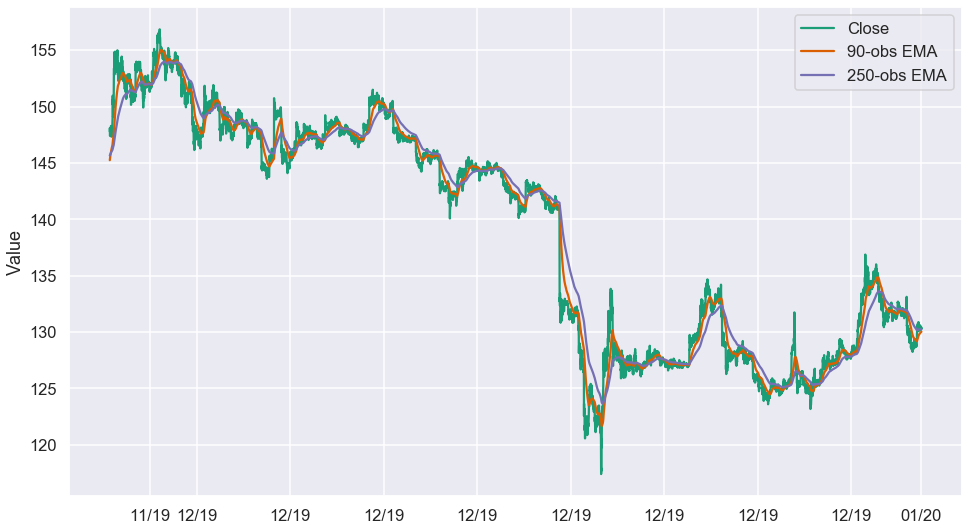

In [5]:
n_s = 90
n_l = 250
operations_train, operations_buy_train  = exponential_moving_average(df_train, n_s, n_l, fee )
operations_val, operations_buy_val  = exponential_moving_average(df_val, n_s, n_l, fee )
operations_test, operations_buy_test  = exponential_moving_average(df_test, n_s, n_l, fee )

# How oftern are trades being executed, every 2 days on average
1/(operations_buy_train.shape[0]/365)
1/(operations_buy_val.shape[0]/365)
1/(operations_buy_test.shape[0]/182)

# Plot of last n rows

# Exponential moving average

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
my_year_month_fmt = mdates.DateFormatter('%m/%y')
sns.set(style='darkgrid', context='talk', palette='Dark2')
temp = operations_train.tail(10000)
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(temp.Open_Time, temp.Close, label='Close')
ax.plot(temp.Open_Time, temp.mae_short, label = str(n_s)+'-obs EMA')
ax.plot(temp.Open_Time, temp.mae_long, label = str(n_l)+'-obs EMA')

ax.legend(loc='best')
ax.set_ylabel('Value')
ax.xaxis.set_major_formatter(my_year_month_fmt)

##### Finding the optimal trading strategy, in terms of shapre ratio (returns adjusted for volatility)

In [6]:

comp_stats = []
for n_s in range(10, 100, 10):
    for n_l in range(n_s, 500, 10):

        operations_train, operations_buy_train  = exponential_moving_average(df_train, n_s, n_l, fee )
        operations_val, operations_buy_val  = exponential_moving_average(df_val, n_s, n_l, fee )
        operations_test, operations_buy_test  = exponential_moving_average(df_test, n_s, n_l, fee )


        statistics = list(
                total_return_sharpe(operations_buy_train.r) + \
                total_return_sharpe(operations_buy_train.r_fee) +\
                total_return_sharpe(operations_buy_val.r) + \
                total_return_sharpe(operations_buy_val.r_fee) + \
                total_return_sharpe(operations_buy_test.r) + \
                total_return_sharpe(operations_buy_test.r_fee)  )
        
        stats = [n_s,n_l]  + statistics    
    
        comp_stats.append(stats)    
        
cols = ['n_s','n_l',
     'r_train','sharpe_train','r_fee_train','sharpe_fee_train',
     'r_val','sharpe_val','r_fee_val','sharpe_fee_val',
     'r_test','sharpe_test','r_fee_test','sharpe_fee_test']        
results = pd.DataFrame(comp_stats, columns = cols)


In [7]:
'''
'n_s': Number of lag observations in ema short, alpha=1/(n_s+1)
'n_s': Number of lag observations in ema short, alpha=1/(n_s+1)
'n_l': Number of lag observations in ema long, alpha=1/(n_s+1)
'r_': Cumulative return over period
'sharpe_': Cumulative return over standard deviation on period
'r_fee_': Cumulative return over period w/ fees
'sharpe_fee_': Cumulative return w/ fees over standard deviation on period
'''
# Best 10 periods in terms of sharpe ratio in validation set
results.sort_values(by = 'sharpe_fee_val', ascending = False).head(10)

,n_s,n_l,r_train,sharpe_train,r_fee_train,sharpe_fee_train,r_val,sharpe_val,r_fee_val,sharpe_fee_val,r_test,sharpe_test,r_fee_test,sharpe_fee_test
380,90,250,0.554203,15.845904,0.111316,3.189152,0.608226,12.630070,0.223202,4.644172,0.893770,20.135826,0.684087,15.442736
379,90,240,0.563162,16.393218,0.114260,3.332693,0.597172,12.707881,0.206174,4.396182,0.812237,18.454812,0.598719,13.630729
386,90,310,0.484245,13.990491,0.071483,2.069386,0.549278,10.722841,0.212348,4.153695,0.922483,20.440610,0.740729,16.446136
341,80,270,0.503612,14.264415,0.064824,1.839763,0.569374,12.010499,0.184428,3.898154,0.953498,21.310543,0.747694,16.744324
334,80,200,0.419342,13.277742,-0.087243,-2.767937,0.610821,13.830868,0.155827,3.535462,0.532120,13.191089,0.279182,6.934703
381,90,260,0.524690,14.559389,0.103851,2.887489,0.531474,11.210745,0.158597,3.352104,0.938506,20.014015,0.744726,15.913390
387,90,320,0.587064,16.219887,0.184091,5.096417,0.499905,9.521934,0.173069,3.303127,0.900765,19.422556,0.727050,15.708270
375,90,200,0.456475,13.150008,-0.016202,-0.467674,0.562753,11.993355,0.143837,3.071593,0.535039,12.849311,0.298087,7.173103
373,90,180,0.450488,14.158127,-0.058159,-1.831491,0.589210,13.069522,0.136258,3.028460,0.594228,15.128091,0.345164,8.804927
302,70,300,0.478717,13.917343,0.031983,0.931685,0.533591,11.336145,0.140721,2.995599,0.955622,21.035637,0.751813,16.582433


##### The best periods for the ema are 90, 250 for long and short respectively

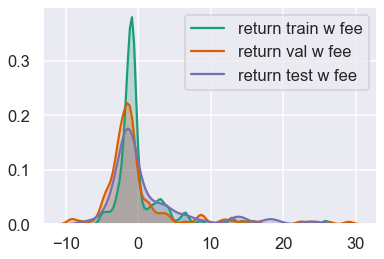

In [9]:
# Around 70% of transactions occur at a loss, but there are extreme events through the year
# which make the strategies proffitable


# Distribution of returns
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(100*operations_buy_train['r_fee'], shade=True, label = 'return train w fee');
sns.kdeplot(100*operations_buy_val['r_fee'], shade=True, label = 'return val w fee');
sns.kdeplot(100*operations_buy_test['r_fee'], shade=True, label = 'return test w fee');

plt.legend()